In [1]:
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from numpy import newaxis, concatenate
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error
from pandas import read_csv, DataFrame,concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
seq_len = 1
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
def predict_sequences_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, window_size-1,predicted[-1], axis=0)
    return predicted

In [3]:
dataset = read_csv('fai1.csv', header = 0, index_col=0)
dataset_stock = read_csv('stock1.csv', header = 0, index_col=0)
values = dataset.values
values_stock = dataset_stock.values
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
values_stock[:,0] = encoder.fit_transform(values_stock[:,0])
values = values.astype('float32')
values_stock = values_stock.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled_stock = scaler.fit_transform(values_stock)
reframed = series_to_supervised(scaled, 1, 1)
reframed_stock = series_to_supervised(scaled_stock, 1, 1)
print(reframed.head())
print(reframed_stock.head())

   var1(t-1)   var1(t)
1   0.182609  0.191304
2   0.191304  0.182609
3   0.182609  0.191304
4   0.191304  0.182609
5   0.182609  0.104348
   var1(t-1)   var1(t)
1   0.157798  0.161468
2   0.161468  0.150459
3   0.150459  0.177982
4   0.177982  0.166972
5   0.166972  0.179817


In [4]:
values = reframed.values
values_stock = reframed_stock.values
n_train_hours = 205
n_end = n_train_hours + 5
train = values[:n_train_hours, :]
train_stock = values_stock[:n_train_hours,:]
test = values[n_train_hours:n_end :]
test_stock = values_stock[n_train_hours:n_end:]
train_X, train_y = train[:,:-1], train[:, -1]
train_stock_X, train_stock_y = train_stock[:,:-1], train_stock[:, -1]
test_X, test_y = test[:, :-1], test[:,-1]
test_stock_X, test_stock_y = test_stock[:, :-1], test_stock[:,-1] 
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_stock_X = train_stock_X.reshape((train_stock_X.shape[0], 1, train_stock_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0],1, test_stock_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_stock_X.shape, train_stock_y.shape, test_stock_X.shape, test_stock_y.shape)

(205, 1, 1) (205,) (5, 1, 1) (5,)
(205, 1, 1) (205,) (5, 1, 1) (5,)


In [6]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
start = time.time()
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
print("> Compilation Time :", time.time() - start)
history = model.fit(train_X, train_y, epochs=30, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#print (seq_len)
predicted = predict_sequences_full(model, test_X, seq_len)

> Compilation Time : 0.023003816604614258
Train on 205 samples, validate on 5 samples
Epoch 1/30
1s - loss: 0.0253 - val_loss: 0.0276
Epoch 2/30
0s - loss: 0.0180 - val_loss: 0.0149
Epoch 3/30
0s - loss: 0.0153 - val_loss: 0.0056
Epoch 4/30
0s - loss: 0.0113 - val_loss: 0.0026
Epoch 5/30
0s - loss: 0.0114 - val_loss: 0.0017
Epoch 6/30
0s - loss: 0.0109 - val_loss: 0.0019
Epoch 7/30
0s - loss: 0.0116 - val_loss: 0.0017
Epoch 8/30
0s - loss: 0.0128 - val_loss: 0.0021
Epoch 9/30
0s - loss: 0.0113 - val_loss: 0.0021
Epoch 10/30
0s - loss: 0.0121 - val_loss: 0.0017
Epoch 11/30
0s - loss: 0.0123 - val_loss: 0.0022
Epoch 12/30
0s - loss: 0.0121 - val_loss: 0.0035
Epoch 13/30
0s - loss: 0.0110 - val_loss: 0.0018
Epoch 14/30
0s - loss: 0.0124 - val_loss: 0.0018
Epoch 15/30
0s - loss: 0.0129 - val_loss: 0.0017
Epoch 16/30
0s - loss: 0.0107 - val_loss: 0.0018
Epoch 17/30
0s - loss: 0.0118 - val_loss: 0.0018
Epoch 18/30
0s - loss: 0.0115 - val_loss: 0.0029
Epoch 19/30
0s - loss: 0.0107 - val_loss:

[0.64116269, 0.60904253, 0.5814532, 0.55792636, 0.53799289]


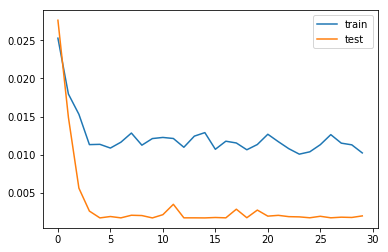

In [7]:
print (predicted)
l = len(predicted)
#print (l)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

[ 0.64116269  0.60904253  0.5814532   0.55792636  0.53799289] [ 0.21651377  0.21834862  0.18165138  0.22018349  0.23853211]
MSE: 0.139311


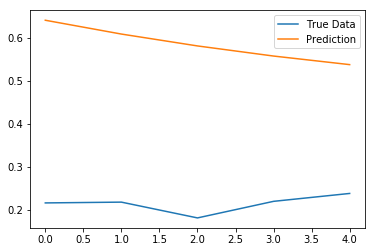

In [8]:
predicted = np.reshape(predicted, (l,))

print(predicted, test_stock_y)

score = mean_squared_error(predicted, test_stock_y)
    
print("MSE: %f" % score)
plot_results(predicted, test_stock_y)